In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

## Training,Validation and Testing data

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)                          
#                                    rotation_range=5
#                                    width_shift_range=0.2,
#                                    height_shift_range=0.2,
#                                    #shear_range=0.2,
#                                    zoom_range=0.2,
#                                    horizontal_flip=True,
#                                    vertical_flip=True,
#                                    fill_mode='nearest')
                        

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [9]:
train_dataset  = train_datagen.flow_from_directory(directory = 'C:\\Users\\arkap\\Desktop\\Project\\fer2013img\\train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   shuffle=True,
                                                   batch_size = 64)

Found 22968 images belonging to 7 classes.


In [10]:
valid_dataset = valid_datagen.flow_from_directory(directory = 'C:\\Users\\arkap\\Desktop\\Project\\fer2013img\\test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  shuffle=True,
                                                  batch_size = 64)

Found 1432 images belonging to 7 classes.


In [11]:
test_dataset = test_datagen.flow_from_directory(directory = 'C:\\Users\\arkap\\Desktop\\Project\\fer2013img\\test',
                                                target_size = (48,48),
                                                class_mode = 'categorical',
                                                shuffle=True,
                                                batch_size = 64)

Found 7178 images belonging to 7 classes.


## Model Creation and plotting accuracy

In [12]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [13]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [14]:
no_of_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

In [15]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

In [16]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='C:/Users/arkap/Desktop/Project/convnet.png', show_shapes=True,show_layer_names=True,dpi=350)
#Image(filename='convnet.png') 

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [17]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [18]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

history=model.fit(train_dataset,validation_data=test_dataset,epochs = 15,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/15
359/359 [==============================] - 1606s 4s/step - loss: 1.7933 - accuracy: 0.8545 - precision: 0.4640 - recall: 0.1175 - auc: 0.7097 - f1_score: 0.1844 - val_loss: 1.8012 - val_accuracy: 0.8664 - val_precision: 0.6450 - val_recall: 0.1438 - val_auc: 0.6880 - val_f1_score: 0.2344
Epoch 2/15
359/359 [==============================] - 1627s 5s/step - loss: 1.4367 - accuracy: 0.8747 - precision: 0.6712 - recall: 0.2415 - auc: 0.8178 - f1_score: 0.3536 - val_loss: 1.3958 - val_accuracy: 0.8784 - val_precision: 0.7279 - val_recall: 0.2374 - val_auc: 0.8250 - val_f1_score: 0.3562
Epoch 3/15
359/359 [==============================] - 1151s 3s/step - loss: 1.2852 - accuracy: 0.8828 - precision: 0.7087 - recall: 0.3050 - auc: 0.8575 - f1_score: 0.4251 - val_loss: 1.2600 - val_accuracy: 0.8862 - val_precision: 0.7814 - val_recall: 0.2824 - val_auc: 0.8623 - val_f1_score: 0.4111
Epoch 4/15
359/359 [==============================] - 937s 3s/step - loss: 1.2071 - accuracy: 0.8882

## Plotting results and accuracy

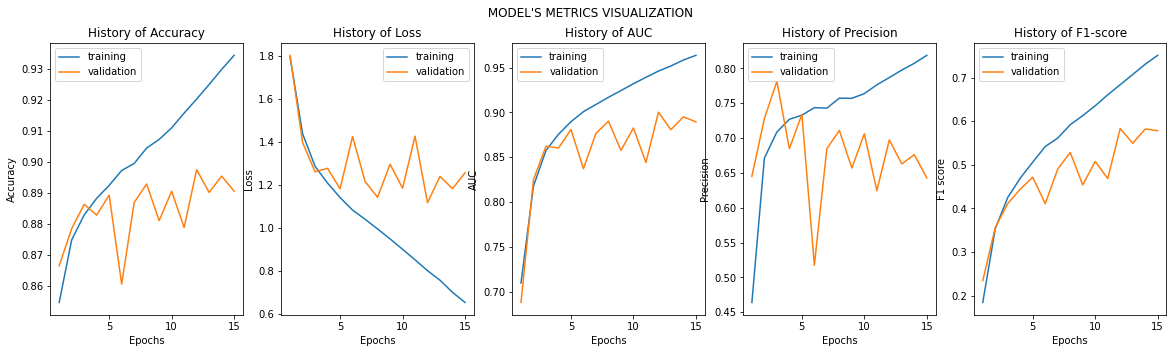

In [19]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [20]:
model.save_weights('model.h5')  # creates a HDF5 file 'my_model.h5'
print('Saved to disc')

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
print("Successful") 

Saved to disc
Successful


In [21]:
import numpy as np
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import load_model
from keras.models import model_from_json

model = model_from_json(open("model.json", "r").read())
model.load_weights('model.h5')

Y_pred = model.predict_generator(test_dataset, 1157)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_dataset.classes, y_pred))
print('Classification Report')
#target_names = ['Negative','Neutral','Positive']
target_names = ['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']
print(classification_report(test_dataset.classes, y_pred, target_names=target_names))

C:\Users\arkap\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[136  13  38 233 229 233  76]
 [ 15   1   5  32  22  26  10]
 [160  11  50 221 265 232  85]
 [281  17  74 389 432 431 150]
 [170   8  51 296 315 269 124]
 [179  17  55 283 289 307 117]
 [112   9  38 189 199 195  89]]
Classification Report
              precision    recall  f1-score   support

       Angry       0.13      0.14      0.14       958
     Disgust       0.01      0.01      0.01       111
        Fear       0.16      0.05      0.07      1024
       Happy       0.24      0.22      0.23      1774
     Neutral       0.18      0.26      0.21      1233
         Sad       0.18      0.25      0.21      1247
    Surprise       0.14      0.11      0.12       831

    accuracy                           0.18      7178
   macro avg       0.15      0.15      0.14      7178
weighted avg       0.18      0.18      0.17      7178

